#### PI7-3: AE & VAE
This notebook contains all the implementation and evaluation of the research performed on autoencoders en variational autoencoders.

In [26]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [27]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE

device(type='cuda')

#### 1.1 Autoencoder
First up is the autoencoder. In short, an autoencoder uses the encoder to reduce the dimensionality of data by compressing it into the latent space, and using a decoder, the data is reconstructed using upsampling. 



Below is the encoder part of the autoencoder. This encoder will take an image of shape (3, 64, 64), since the images are processed in RGB (3 channels) and are 64x64 pixels in size. The encoder has five convolutional layers to reduce the spatial dimensions and expand extracted features. Each layer includes the following:

- BatchNorm2d: Normalizes activations across channels for stability

- LeakyReLU: Allows gradient flow for negative inputs

- Dropout: Regularizes to prevent overfitting

In [ ]:
class Encoder(nn.Module):
    def __init__(self, z_space: int):
        super().__init__()
        self.z_space = z_space
        
        '''Channel sizes: 64 → 128 → 256 → 512 → z_space'''
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64, affine=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(p=0.2),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128, affine=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(p=0.2),

            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256, affine=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(p=0.2),
            
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512, affine=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(p=0.2),

            nn.Conv2d(512, z_space, kernel_size=3, stride=2, padding=0, bias=False)
        )

    def forward(self, X: torch.Tensor):
        return self.net(X)

Below is the decoder, which takes the latent space and will reconstruct the image as close to the original as possible. Using deconvolutions, it is able to reconstruct the data from the latent space back to the original size (3, 64, 64). Similarly to the encoder it uses a combination of batchnorm2d and leakyrelu, however, the final layer simply outputs the RGB image without activation.

In [ ]:
class Decoder(nn.Module):
    def __init__ (self, z_space: int):
        super().__init__()
        self.z_space = z_space

        '''Channel size: z_space → 512 → 256 → 128 → 64 → 3'''
        self.net = nn.Sequential(
            nn.ConvTranspose2d(z_space, 512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512, affine=True),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256, affine=True),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128, affine=True),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64, affine=True),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
        )

    def forward(self, X: torch.Tensor):
        return self.net(X)

The autoencoder class itself simply ties the encoder and decoder together, passing the data through the encoder first, and then through the decoder.

In [30]:
class AutoEncoder(nn.Module):
    def __init__(self, z_space: int):
        super().__init__()
        self.encode = Encoder(z_space)
        self.decode = Decoder(z_space)

    def forward(self, X: torch.Tensor):
        z = self.encode(X)
        y = self.decode(z)
        
        return z, y

In [31]:
enc = Encoder(2)
dec = Decoder(2)
x = torch.randn(16, 3, 64, 64)
dec(enc(x)).shape

torch.Size([16, 3, 64, 64])

When making a dataset, the containing data can be transformed. In this case, images are resized to 64x64 (to ensure they're all of ,the same size), and then turned into pytorch tensors. 

The choice to keep the images in RGB was made, since it was thought that more patterns would be recognized if they were in colour format.

In [ ]:
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
])

In [33]:
'''Adjustable constants'''
EPOCHS = 30
BATCH_SIZE = 256
LEARNING_RATE = 0.03
LEARNING_RATE_GAMMA = 0.9

Z_DIM = 256

NUM_WORKERS = 4

Below, a train/val/test split is made on the dataset. Transformations are also applied.

In [34]:
train_dir = 'data/cifar10/train'
test_dir = 'data/cifar10/test'

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
testval_dataset = datasets.ImageFolder(test_dir, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

X_test_val, y_test_val = zip(*testval_dataset)

X_test_val = torch.stack(X_test_val)
y_test_val = torch.tensor(y_test_val)

splitval = int(0.5 * len(testval_dataset))

test_idx, val_idx = torch.utils.data.random_split(y_test_val, [splitval, splitval])

X_test = X_test_val[test_idx.indices]
y_test = y_test_val[test_idx.indices]

X_val = X_test_val[val_idx.indices]
y_val = y_test_val[val_idx.indices]

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test-Val dataset size: {len(testval_dataset)}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

Train dataset size: 50000
Test-Val dataset size: 10000
X_test shape: torch.Size([5000, 3, 64, 64]), y_test shape: torch.Size([5000])
X_val shape: torch.Size([5000, 3, 64, 64]), y_val shape: torch.Size([5000])


#### 1.2 Training Loop AE
Below is the most important part for the model, namely the training loop. Here, the scheduler, optimizer and loss function are defined as follows:
- **Adam** as optimizer: this method uses gradient descent, but also incorporates a variable learning rate, which adapts the learning rate on observed gradient magnitudes. This was used since it can handle noisey data, and generally has faster convergence than other methods.
- **LR Scheduler**: a scheduler is resonsible for controlling the learning rate. The LR scheduler will reduce the learning rate by a small amount (0.9 in this case) after each epoch. This ensures that the improvement rate stays stable, and so that the model can fine-tune itself in later epochs, since major learning will not be necessary anymore (preventing overfitting).
- **Mean Squared Error** as loss function: this will tell both the user and the model how far off the reconstruction is from the original data.

In [ ]:
generator = AutoEncoder(z_space=Z_DIM).to(DEVICE)

optimizer = torch.optim.Adam(generator.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=LEARNING_RATE_GAMMA)
criterion = nn.MSELoss()

train_history = []
val_history = []

for epoch in range(EPOCHS):
    batch_history = []
    for i, (images, _) in enumerate(train_loader):
        images = images.to(DEVICE)
        '''predict and compute loss'''
        _, preds = generator(images)
        loss = criterion(preds, images)
        batch_history.append(loss.item())
        '''optimization step'''
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        torch.cuda.empty_cache()
    
    '''update learning rate'''
    scheduler.step()
    
    train_history.append(torch.mean(torch.tensor(batch_history)))

    with torch.no_grad():
        _, preds = generator(X_val.to(DEVICE))
        loss = criterion(preds, X_val.to(DEVICE))
        val_history.append(loss.item())
    
    print(f"epoch {epoch}, train_loss {train_history[-1]}, val_loss {val_history[-1]}")

with torch.no_grad():
    z, preds = generator(X_test.to(DEVICE))
    loss = criterion(preds, X_test.to(DEVICE))
    print(f"test_loss {loss.item()}")

epoch 0, train_loss 0.11588307470083237, val_loss 0.049906015396118164
epoch 1, train_loss 0.045966021716594696, val_loss 0.039028607308864594
epoch 2, train_loss 0.031486108899116516, val_loss 0.026739923283457756
epoch 3, train_loss 0.02445770800113678, val_loss 0.022672139108181
epoch 4, train_loss 0.022134417667984962, val_loss 0.021322354674339294
epoch 5, train_loss 0.019974835216999054, val_loss 0.018626172095537186
epoch 6, train_loss 0.01831723377108574, val_loss 0.01866493746638298
epoch 7, train_loss 0.01730039156973362, val_loss 0.016989074647426605
epoch 8, train_loss 0.016672100871801376, val_loss 0.015970103442668915
epoch 9, train_loss 0.016141241416335106, val_loss 0.016251182183623314
epoch 10, train_loss 0.015706777572631836, val_loss 0.015544879250228405
epoch 11, train_loss 0.015462648123502731, val_loss 0.01497654989361763
epoch 12, train_loss 0.015105386264622211, val_loss 0.01480706874281168
epoch 13, train_loss 0.014809809625148773, val_loss 0.01502008084207773

#### 1.3 Evaluation
Below, two visualizations can be seen:
- Latent space projected over t-SNE (t-distributed Stochastic Neighbor Embedding). This is an algorithm than can visualize high-dimensional data, like 256 dimensions from the latent space, into 2 dimensions, so that it can be visualized.
- Loss curve for the training and validation datasets.

For the first, it can be noted that data in the latent space are not entirely random. When looking closely, clusters can be seen, however, there is still alot of overlap between classes. 

For the loss curve, it can be observed how error for both the training and validation sets decrease in a similar manner. No gap occurs between validation and training, meaning the model is learning the underlying patterns in the images without overfitting. Test loss was also calculated to be around 0.0127, which is cimilar to the train and validation loss (see output above).

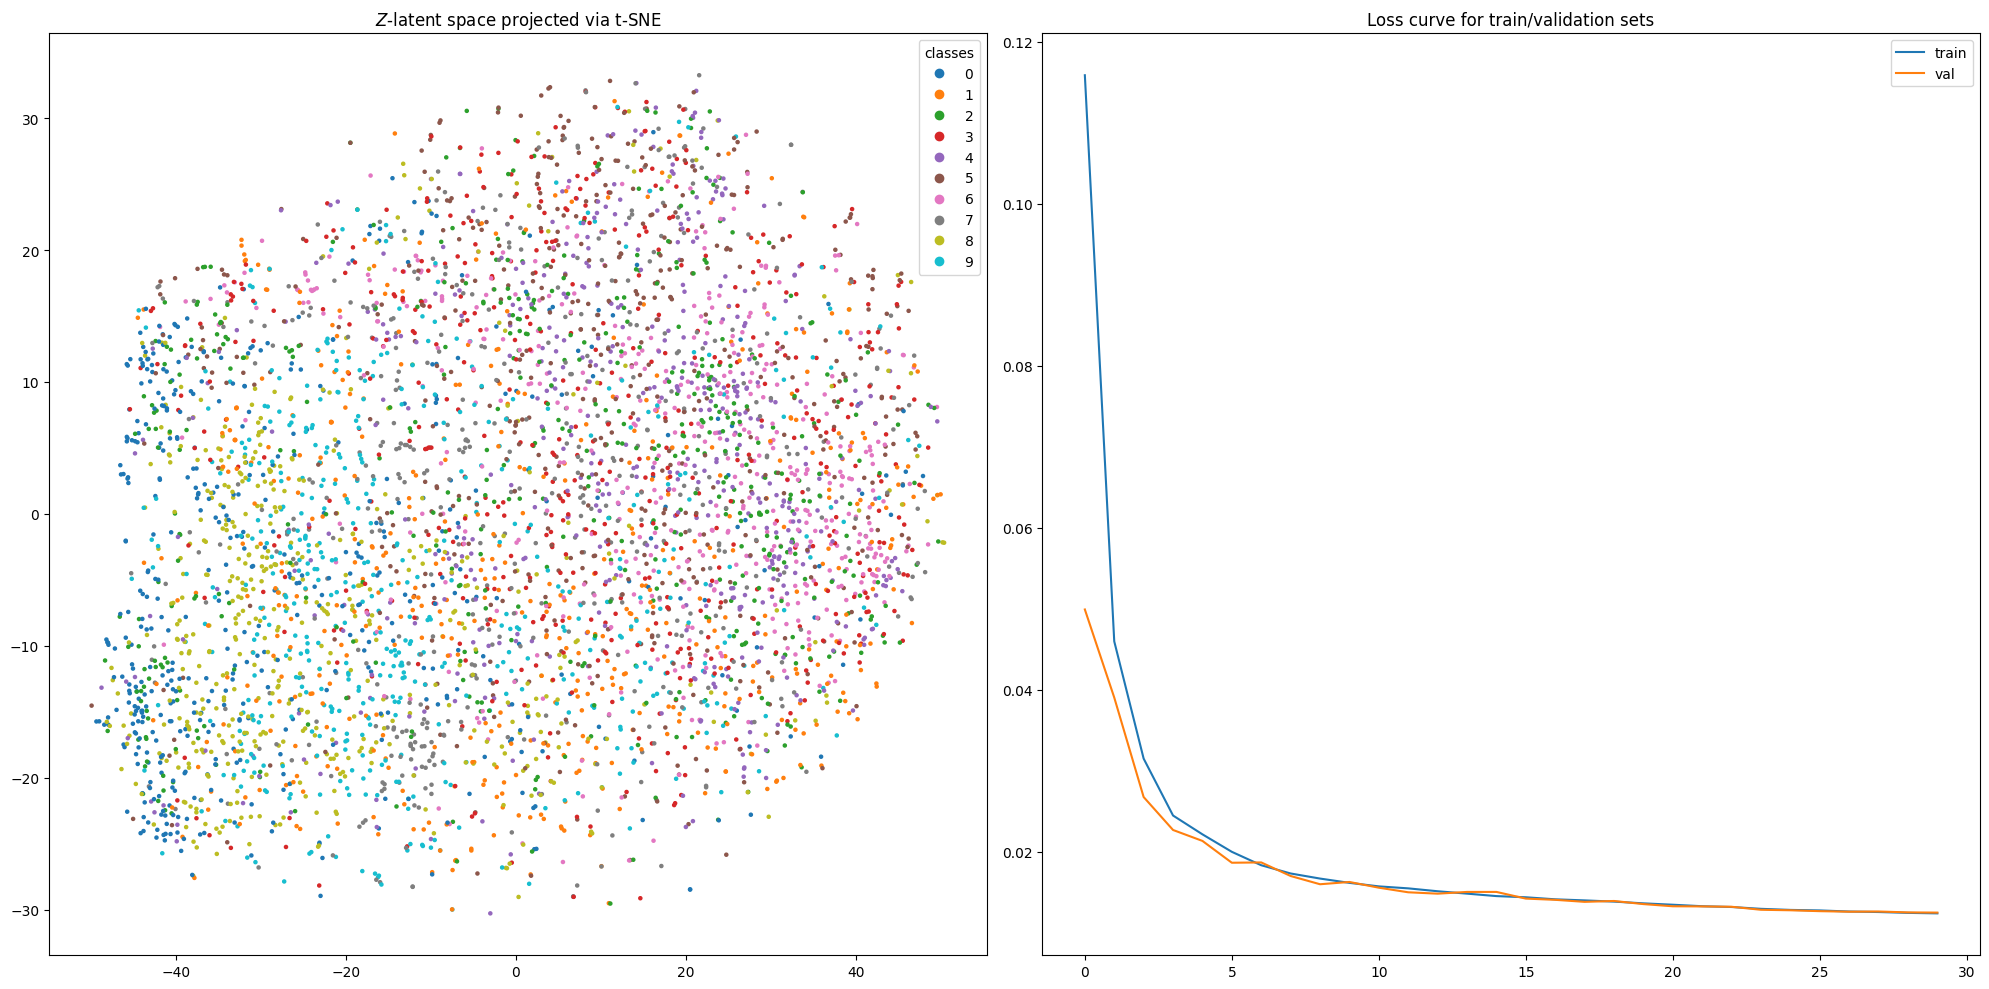

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Flatten z and move to numpy
z = z.view(z.shape[0], -1).cpu().detach().numpy()

# Apply t-SNE to reduce dimensionality
z_proj = TSNE(n_components=2, random_state=42).fit_transform(z)

# Plot t-SNE projection
sc = ax1.scatter(z_proj[:, 0], z_proj[:, 1], c=y_test, s=5, cmap='tab10')
ax1.legend(*sc.legend_elements(), title='classes')
ax1.set_title("$Z$-latent space projected via t-SNE")

# Plot training and validation loss curves
ax2.plot(train_history, label="train")
ax2.plot(val_history, label="val")
ax2.legend()
ax2.set_title("Loss curve for train/validation sets")

plt.tight_layout()
plt.show()


Below is a representation of some samples with output from the model. The row below is the output from the decoder, and albeit somewhat blurry, it does seem that patterns from the original images are being properly recognized.

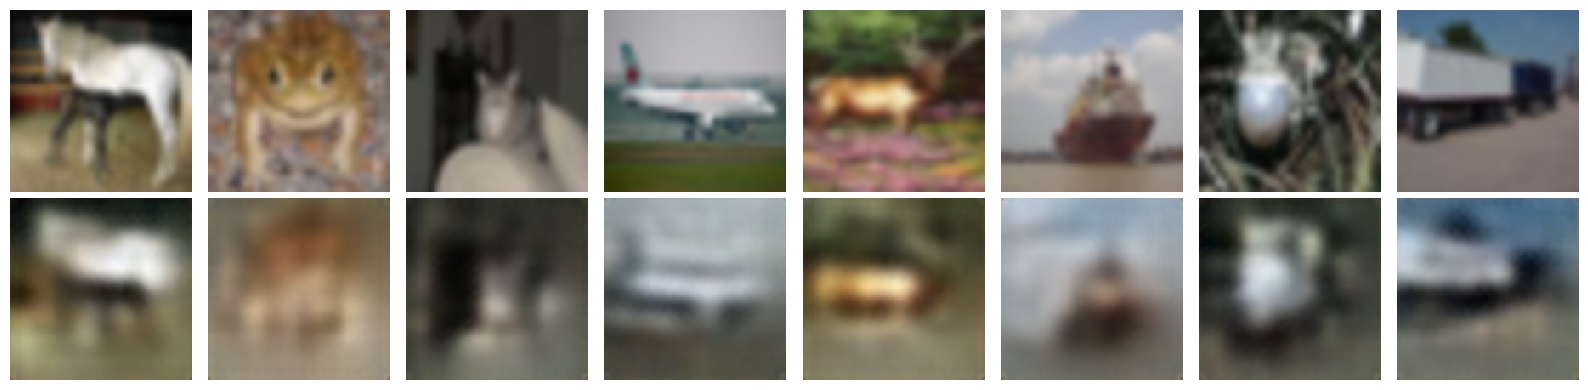

In [37]:
generator.eval()
with torch.no_grad():
    _, recon = generator(X_val[:8].to(DEVICE))

recon = recon.cpu().squeeze().numpy()
original = X_val[:8].squeeze().numpy()

fig, axs = plt.subplots(2, 8, figsize=(16, 4))
for i in range(8):
    axs[0, i].imshow(np.transpose(original[i], (1, 2, 0)))
    axs[0, i].axis('off')
    axs[1, i].imshow(np.transpose(recon[i], (1, 2, 0)))
    axs[1, i].axis('off')

axs[0, 0].set_ylabel("Original", fontsize=12)
axs[1, 0].set_ylabel("Reconstructed", fontsize=12)
plt.tight_layout()
plt.show()

#### 2.1 Variational Autoencoder
This part of the notebook contains the VAE.

Just like the AE, the VAE consists of an encoder and decoder. The difference is that the encoder now compresses data into a distribution over the latent space, instead of a single vectore as was done for the AE. 

The output to the latent space is now the **mean** of the distribution and **log-variance**, since the latent space is now represented as a distribution.

The structure for the encoder an decoder is mostly similar to the layers for the AE.

In [ ]:
class VAEncoder(nn.Module):
    def __init__(self, z_space=3):
        super().__init__()
        self.z_space = z_space
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128, affine=True),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256, affine=True),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512, affine=True),
            nn.ReLU(inplace=True),

            nn.Conv2d(512, z_space, kernel_size=3, stride=2, padding=0, bias=False)
        )

    def forward(self, X: torch.Tensor):
        return self.net(X)

In [ ]:
class VADecoder(nn.Module):
    def __init__(self, z_space=3):
        super().__init__()
        self.z_space = z_space
        self.net = nn.Sequential(
            nn.ConvTranspose2d(z_space, 512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512, affine=True),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256, affine=True),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128, affine=True),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64, affine=True),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
        )

    def forward(self, X: torch.Tensor):
        return self.net(X)

In [40]:
enc = VAEncoder(3)
dec = VADecoder(3)
x = torch.randn(16, 3, 64, 64)
dec(enc(x)).shape

torch.Size([16, 3, 64, 64])

In the VAE class, the logic for constructing the latent space is implemented. 

<code>encode(X)</code> will return the parameters for the Gaussian distribution, namely the mean and log-variance.

In turn, the decoder will sample from this Gaussian distribution using the **reparameterization trick**. Since sampling directly from the distribution samples randomly, random samples will need to be expressed as a deterministic function of the mean, and a separate random variable. In short, this makes backpropogation possible, meaning that it can be determined how much error can be contributed to the weight and how much the weights should be adjusted to reduce error.

Forward will perform a full pass for the data; from encode -> sample, -> decode -> output.

In [ ]:
class VAE(nn.Module):
    def __init__(self, z_size=2):
        super().__init__()
        self.z_size = z_size
        self.enc = VAEncoder(2*z_size)
        self.dec = VADecoder(z_size)
    
    def encode(self, X: torch.Tensor):
        h = self.enc(X)                                             # (batch_size, 2*z_dim, 1, 1)
        
        '''Compute the mean for forward pass'''
        mu = h[:, :self.z_size].view(-1, self.z_size)               # mean vec mu: (batch_size, z_dim)
        
        '''Compute the log-variance for forward pass'''
        log_var = h[:, self.z_size:].view(-1, self.z_size)          # log variance:(batch_size, z_dim)
        
        return mu, log_var
    
    def decode(self, mu: torch.Tensor, log_var: torch.Tensor):
        '''Generate random noise from a standard normal distribution for each input in a batch'''
        eps = torch.randn(mu.shape[0], self.z_size).to(mu.device)   # random eps \sim N(0, I)
        
        '''Apply reparameterization trick'''
        z = mu + torch.exp(0.5 * log_var) * eps
        
        '''Transform z from [batch_size, z_dim] → [batch_size, z_dim, 1, 1] so it fits in the transpose decoder'''
        z = z.reshape(*z.shape, 1, 1)                               # (batch_size, z_dim, 1, 1)
        
        y = self.dec(z)
        return y, z
    
    def forward(self, X: torch.Tensor):
        mu, log_var = self.encode(X)
        y, z = self.decode(mu, log_var)
        return y, z, mu, log_var

In [42]:
x = torch.randn(16, 3, 64, 64)
g = VAE(z_size=2)
y, z, mu, log_var = g(x)
y.shape, z.shape, mu.shape, log_var.shape

(torch.Size([16, 3, 64, 64]),
 torch.Size([16, 2, 1, 1]),
 torch.Size([16, 2]),
 torch.Size([16, 2]))

In [43]:
EPOCHS = 80
BATCH_SIZE = 512
LEARNING_RATE = 0.001
LEARNING_RATE_GAMMA = 0.9
NUM_WORKERS = 4
# Model constants
Z_DIM = 512
LAMBDA_REC_ERR = 1000

# check for possible GPU usage
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [44]:
train_dir = 'data/cifar10/train'
test_dir = 'data/cifar10/test'

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
testval_dataset = datasets.ImageFolder(test_dir, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

X_test_val, y_test_val = zip(*testval_dataset)

X_test_val = torch.stack(X_test_val)
y_test_val = torch.tensor(y_test_val)

splitval = int(0.5 * len(testval_dataset))

test_idx, val_idx = torch.utils.data.random_split(y_test_val, [splitval, splitval])

X_test = X_test_val[test_idx.indices]
y_test = y_test_val[test_idx.indices]

X_val = X_test_val[val_idx.indices]
y_val = y_test_val[val_idx.indices]

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test-Val dataset size: {len(testval_dataset)}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

Train dataset size: 50000
Test-Val dataset size: 10000
X_test shape: torch.Size([5000, 3, 64, 64]), y_test shape: torch.Size([5000])
X_val shape: torch.Size([5000, 3, 64, 64]), y_val shape: torch.Size([5000])


In [45]:
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")

X_val shape: torch.Size([5000, 3, 64, 64])
X_test shape: torch.Size([5000, 3, 64, 64])


#### 2.2 Training Loop VAE
Below is the training loop for the VAE. It uses the following methods for optimization, scheduling the learning rate and the loss function:
- Once again, **Adam** is used for optimization.
- The **LR scheduler** is also reused.
- **Binary Cross Entropy (BSE)** as the loss function. In an effort to improve the output for the VAE, BCE was used, which uses binary pixel data, which can often result in sharper reconstructions. BCE matches the semantics for binary probability, making it possible to process binary data.

**KL divergence** is also used. This is useful, since the model gets penalized for when the distribution in the latent space deviates too much from the standard normal.

In [ ]:
genvae = VAE(z_size=Z_DIM).to(DEVICE)

optimizer = torch.optim.Adam(genvae.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=LEARNING_RATE_GAMMA)
criterion = nn.BCEWithLogitsLoss()

train_history = []
val_history = []

for epoch in range(EPOCHS):
    batch_history = []
    for i, (images, _) in enumerate(train_loader):
        images = images.to(DEVICE)
        # predict and compute loss
        preds, _, mu, log_var = genvae(images)
        
        '''KL regularization'''
        kl_reg = torch.mean(- 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), dim=1))
        
        '''Influence from KL regularization gets scaled up in total loss'''
        rec_error = LAMBDA_REC_ERR * criterion(preds, images)
        loss = rec_error + kl_reg
        
        batch_history.append(loss.item())
        # optimization step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # update learning rate
    scheduler.step()
    
    train_history.append(torch.mean(torch.tensor(batch_history)))

    with torch.no_grad():
        preds, _, mu, log_var = genvae(X_val.to(DEVICE))
        kl_reg = torch.mean(- 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), dim=1))
        rec_error = LAMBDA_REC_ERR * criterion(preds, X_val.to(DEVICE))
        loss = rec_error + kl_reg
        val_history.append(loss.item())
    
    print(f"epoch {epoch}, train_loss {train_history[-1]}, val_loss {val_history[-1]}")

with torch.no_grad():
    preds, z, mu, sigma = genvae(X_test.to(DEVICE))
    kl_reg = torch.mean(- 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), dim=1))
    rec_error = LAMBDA_REC_ERR * criterion(preds, X_test.to(DEVICE))
    loss = rec_error + kl_reg
    print(f"test_loss {loss.item()}")


epoch 0, train_loss 695.3399047851562, val_loss 653.2155151367188
epoch 1, train_loss 647.8663940429688, val_loss 642.0870361328125
epoch 2, train_loss 638.15087890625, val_loss 637.1845092773438
epoch 3, train_loss 634.98779296875, val_loss 634.3551025390625
epoch 4, train_loss 632.7168579101562, val_loss 632.3849487304688
epoch 5, train_loss 630.6070556640625, val_loss 630.0535888671875
epoch 6, train_loss 628.5118408203125, val_loss 628.526611328125
epoch 7, train_loss 627.4288330078125, val_loss 627.73046875
epoch 8, train_loss 626.766357421875, val_loss 627.2647094726562
epoch 9, train_loss 626.3133544921875, val_loss 626.99365234375
epoch 10, train_loss 625.7572631835938, val_loss 626.2884521484375
epoch 11, train_loss 625.4187622070312, val_loss 625.9286499023438
epoch 12, train_loss 624.9442749023438, val_loss 625.7021484375
epoch 13, train_loss 624.54541015625, val_loss 625.342529296875
epoch 14, train_loss 624.1487426757812, val_loss 625.1463623046875
epoch 15, train_loss 623

#### 2.3 Evaluation
Just as for the AE, the latent space was projected over t-SNE, where each point represents a coded class in the latent space. The distribution is once again fairly mixed and continuous, meaning it is not a random distribution for the points. Some clusters do seem to form if one looks closely, meaning that classification does take place.

On the right, the training process is visualized with a loss curve. This graph shows that the training curve steadily decreases, meaning that the model learns in a stable manner. After  20 or so epochs, the results plateau and a gap forms between the training and validation loss, meaning there is slight overfitting taking place.

Now let's look at the images that were actually reconstructed.

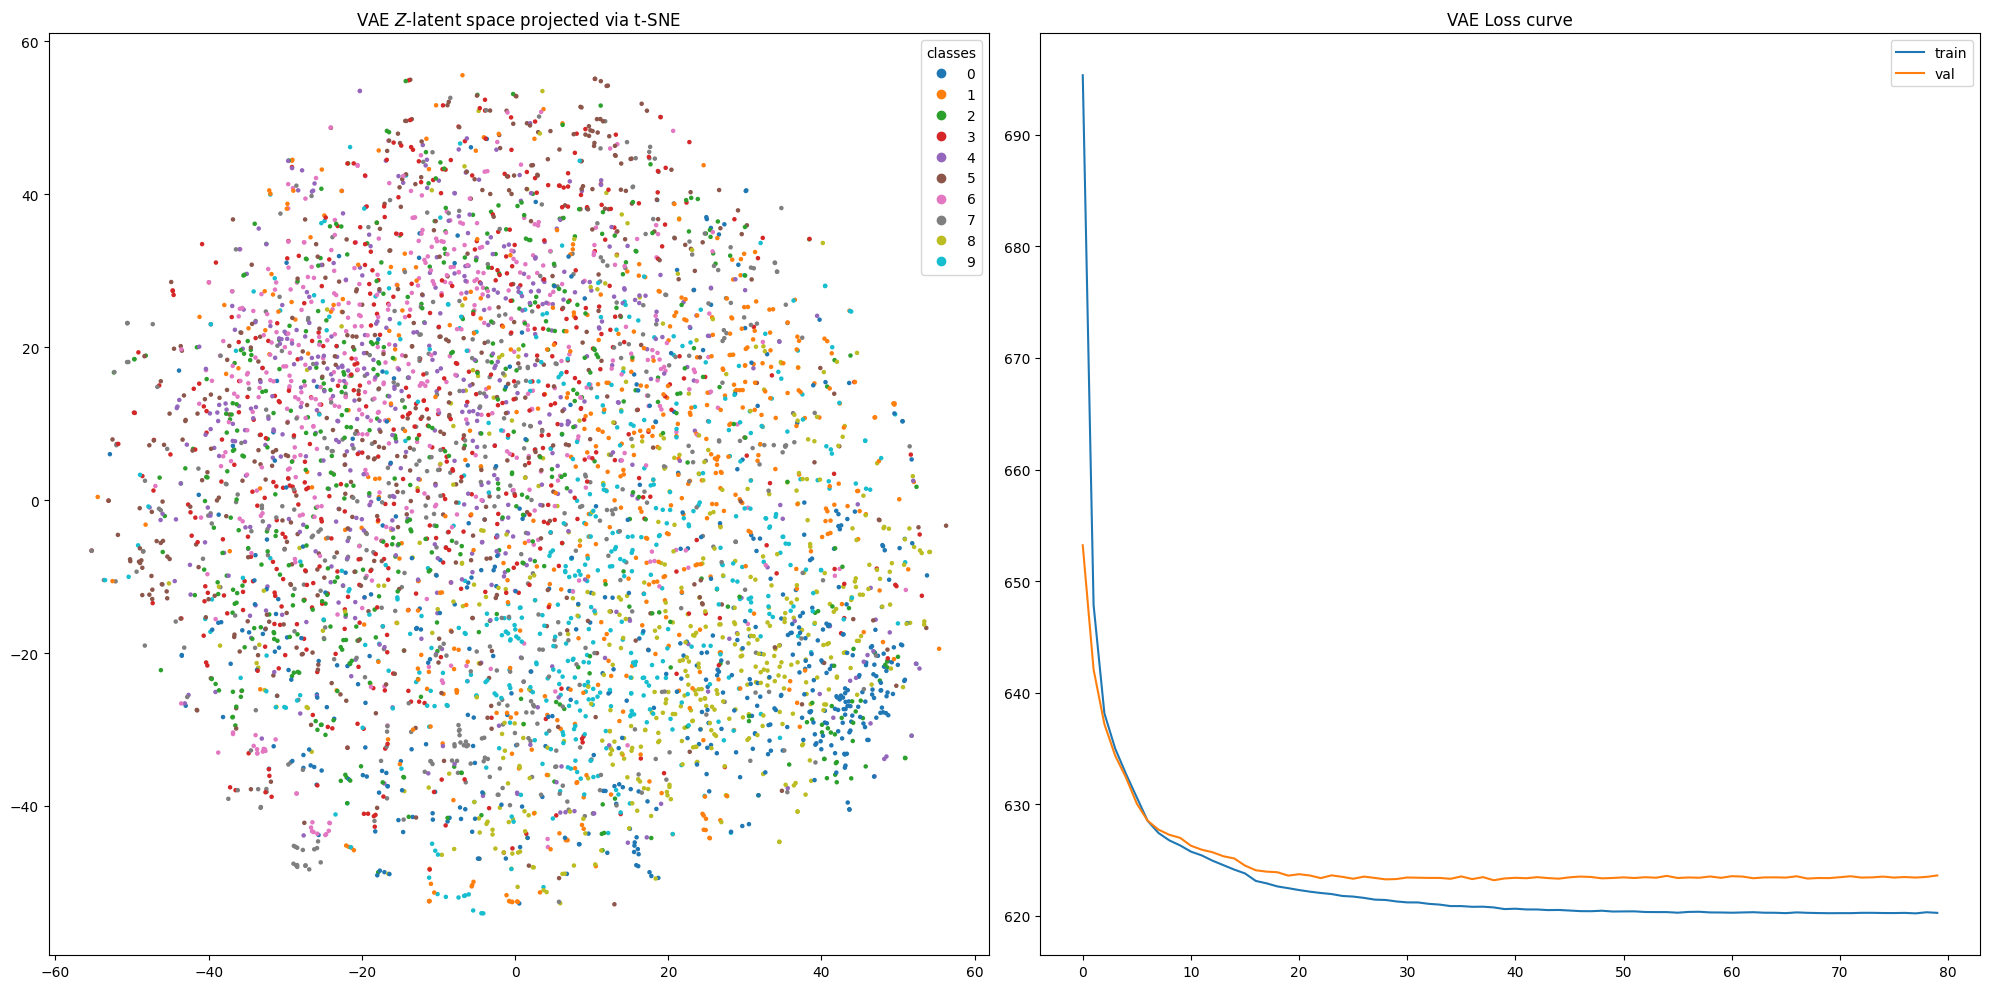

In [50]:
from sklearn.manifold import TSNE

with torch.no_grad():
    _, _, mu, _ = genvae(X_test.to(DEVICE))

z = mu.cpu().numpy()

z_proj = TSNE(n_components=2, random_state=42).fit_transform(z)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

sc = ax1.scatter(z_proj[:, 0], z_proj[:, 1], c=y_test, s=5, cmap='tab10')
ax1.legend(*sc.legend_elements(), title='classes')
ax1.set_title("VAE $Z$-latent space projected via t-SNE")


ax2.plot(train_history, label="train")
ax2.plot(val_history, label="val")
ax2.legend()
ax2.set_title("VAE Loss curve")

plt.tight_layout()
plt.show()


torch.Size([3, 64, 64])


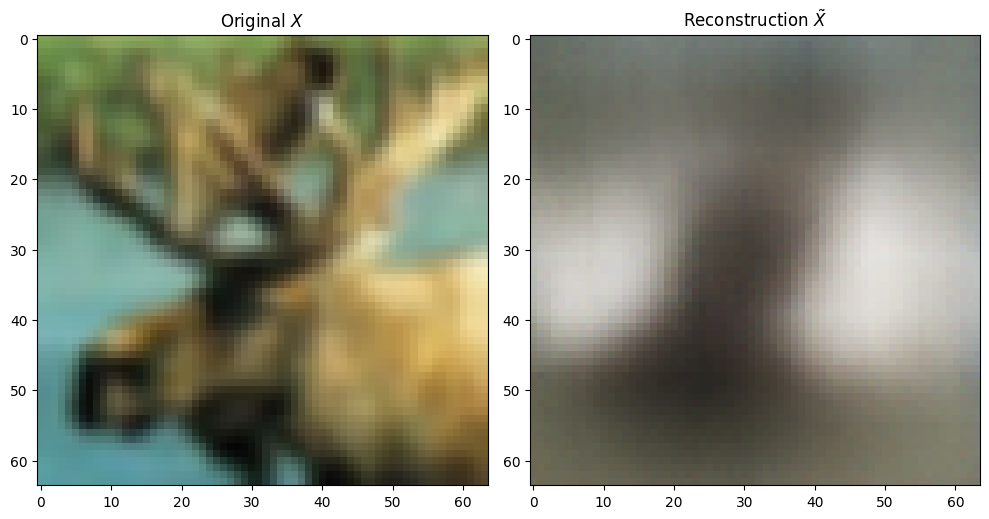

In [52]:
idx = 10

X_sample = X_test[idx].to(DEVICE)

print(X_sample.shape)
X_sample = X_sample.unsqueeze(0)  # (1, 3, 64, 64)
y_pred, _, _, _ = genvae(X_sample)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.set_title("Original $X$")
ax2.set_title(r"Reconstruction $\tilde{X}$")

ax1.imshow(X_sample.squeeze(0).permute(1,2,0).cpu())
ax2.imshow(F.sigmoid(y_pred).detach().cpu().squeeze(0).permute(1,2,0))

plt.tight_layout()

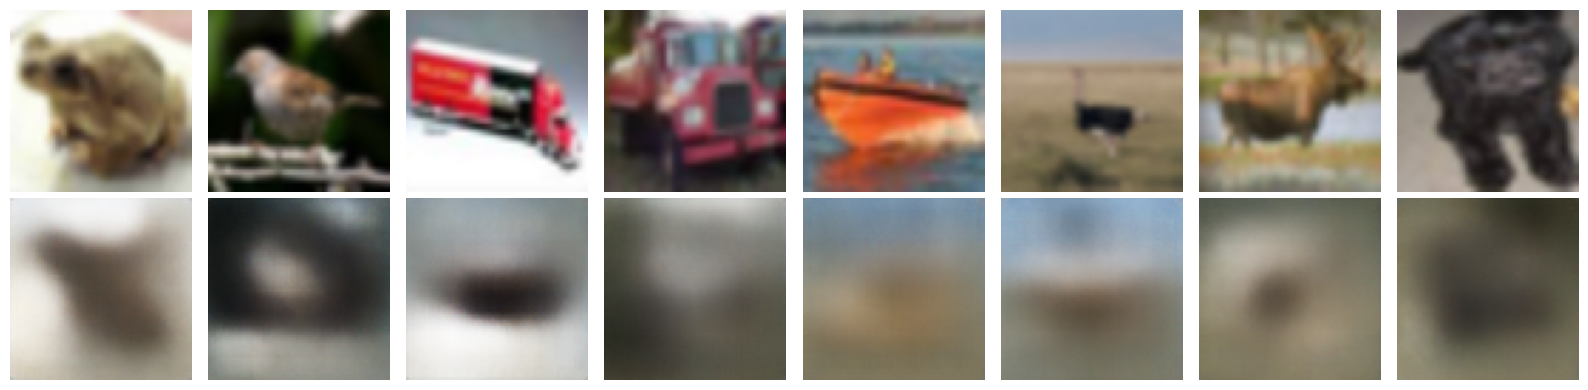

In [53]:
X_batch = X_test[:8].to(DEVICE)  # or any other size you'd like

with torch.no_grad():
    y_pred, _, _, _ = genvae(X_batch)  # Run through VAE

# Postprocess for plotting
recon = torch.sigmoid(y_pred).cpu().squeeze().numpy()  # Apply sigmoid
original = X_batch.cpu().squeeze().numpy()

# Plot: 2 rows (original vs reconstructed)
fig, axs = plt.subplots(2, 8, figsize=(16, 4))
for i in range(8):
    axs[0, i].imshow(np.transpose(original[i], (1, 2, 0)))
    axs[0, i].axis('off')
    axs[1, i].imshow(np.transpose(recon[i], (1, 2, 0)))
    axs[1, i].axis('off')

axs[0, 0].set_ylabel("Original", fontsize=12)
axs[1, 0].set_ylabel("Reconstructed", fontsize=12)
plt.tight_layout()
plt.show()

Text(0, 0.5, '$Z_2$')

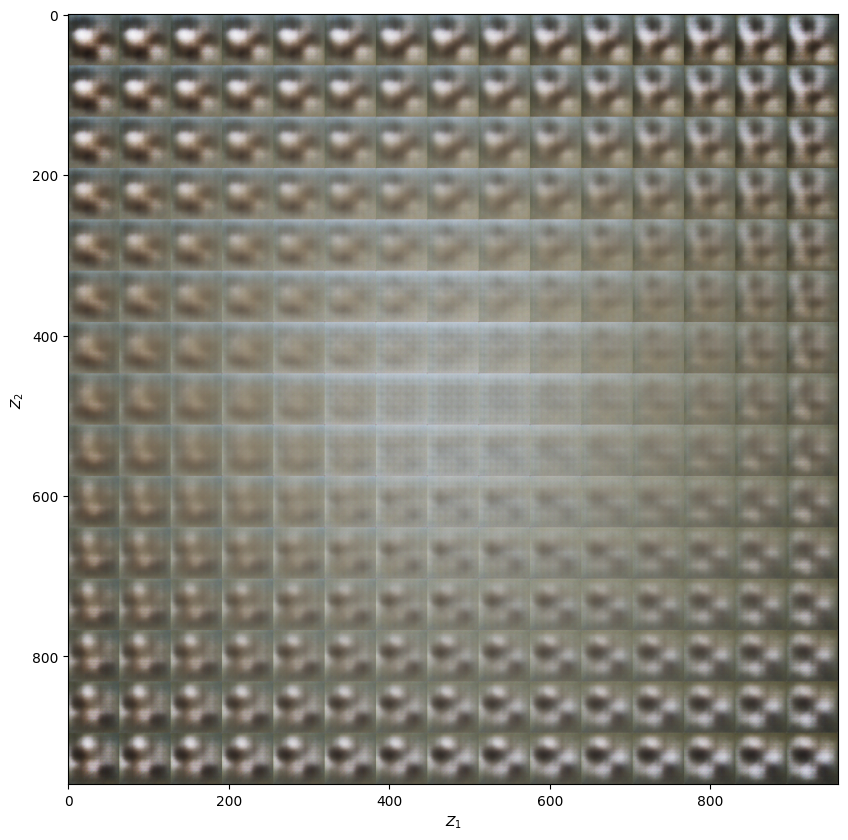

In [ ]:
h, w = 15, 15
z_dim = 512

z1_range = torch.linspace(-1000, 1000, h)
z2_range = torch.linspace(-1000, 1000, w)

z1, z2 = torch.meshgrid(z1_range, z2_range)
zz = torch.zeros(h * w, z_dim, 1, 1).to('cuda')
zz[:, :2, 0, 0] = torch.stack([z1.flatten(), z2.flatten()], dim=1)
#zz = torch.stack([z1, z2], dim=-1).reshape(-1, 2, 1, 1).to('cuda')

y_preds = torch.sigmoid(genvae.dec(zz)).squeeze().cpu().detach()
#y_preds = y_preds.reshape(h, w, 64, 64).permute(1, 2, 0, 3).reshape(h*64, -1)

y_preds = y_preds.reshape(h, w, 3, 64, 64)  # [15, 15, 3, 64, 64]
y_preds = y_preds.permute(0, 3, 1, 4, 2)    # [15, 64, 15, 64, 3]
y_preds = y_preds.reshape(h * 64, w * 64, 3)

plt.figure(figsize=(10, 10))
plt.imshow(y_preds)
plt.axis('image')
plt.xlabel(r'$Z_1$')
plt.ylabel(r'$Z_2$')

As can be seen in the ouput, the images remain very blurry, where shapes are vaguely preserved. The last image is a 2D representation of the latent transversal grid. This output can point out that the model for the VAE hasn't learned much about the variation in the latent space, meaning classes and shapes.

One reason for this could be the implementation of KL divergence. The current implementation might be too aggressive in correcting for the total loss. Since KL divergence penalizes vectors that stray too far off the normal distribution, the values for these vectors get squashed closer to $z$ (the mean). This will cause data in the latent space to move closer to the mean, resulting in blurry output.

#### 3. Conclusion
For this research, autoencoders and variational autoencoders were researched for unsupervised image classification and generation.
For the autoencoder, when the layers are set up, and the hyperparameters have been tweaked, it can be a strong and effective method for reducing data in dimension, and reconstructing the data from a compressed latent space. It excels in its simplicity, where once all the convolutional layers have been constructed, one can quickly train the model and expect strong reconstructions.

For the variational autoencoder, the added complexity comes in the way in reconstructs data from the latent space. It was observed that when regularization is too aggresive with KL divergence, latent encodings can become too generic, providing blurry output. 

Overall, while autoencoders are well suited for reconstruction-focused tasks, variational autoencoders present a powerful framework for generative tasks and learning meaningful latent structures, especially when carefully tuned.